In [70]:
import pandas as pd
import geopandas as gpd
import bokeh
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.plotting import figure, show
from shapely.geometry import Point
from dateutil.parser import parse
import matplotlib.pyplot as plt
import requests
from requests.exceptions import Timeout
import json
from collections import defaultdict
from datetime import timedelta


# Read in csv (downloaded from Cambridge's Open Data Portal)
df = pd.read_csv('seeclickfix.csv')

In [20]:
def get_winter(date):
    # Cambridge's see click fix snow tickets start in January 2016
    if date < parse('06/01/2016'):
        return '2015/2016'
    elif date < parse('06/01/2017'):
        return '2016/2017'
    elif date < parse('06/01/2018'):
        return '2017/2018'
    elif date < parse('06/01/2019'):
        return '2018/2019'
    else:
        return '2019/2020'

# Get a list of all icy or unshoveled sidewalks created since 12/01/19
df.head()
snowy = df[df['issue_type'] == 'Icy or Unshoveled Sidewalk']

# Turn into a geopandas dataframe
geometry = [Point(xy) for xy in zip(snowy.lng, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(snowy, crs=crs, geometry=geometry)

# Turn the created and closed dates into datetime objects
gdf = gdf.assign(ticket_created_date_time=gdf['ticket_created_date_time'].map(lambda x: parse(x)))

# Create a winter column for each ticket
gdf['winter'] = gdf.apply(lambda x: get_winter(x['ticket_created_date_time']), axis=1)

still_open = gdf[gdf['ticket_closed_date_time'].isna()]
closed = gdf[gdf['ticket_closed_date_time'].notna()]

closed = closed.assign(ticket_closed_date_time=closed['ticket_closed_date_time'].map(lambda x: parse(x)))
closed = closed.assign(days_open=closed['ticket_closed_date_time'] - closed['ticket_created_date_time'])

closed['days_open'] = closed['days_open'].apply(lambda x: pd.Timedelta.round(x, 'd').days)
closed.head()

,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,winter,days_open
19,3211993,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy or Unshoveled Sidewalk,2017-02-22 14:18:28,2017-02-15 15:43:45,02/22/2017 02:18:28 PM,"27 Western Avenue Cambridge, MA",42.365244,-71.106128,"(42.3652438914, -71.1061284509)",NaN,POINT (-71.10613 42.37417),2016/2017,7
82,3204837,Cambridge,Icy or Unshoveled Sidewalk,closed,"Resident states lots of ""rubble"" was pushed on...",2017-02-22 14:23:01,2017-02-13 09:19:29,02/22/2017 02:23:01 PM,"Pine Street Cambridge, MA",42.365203,-71.097903,"(42.3652029, -71.0979028)",NaN,POINT (-71.09790 42.37212),2016/2017,9
83,3268761,Cambridge,Icy or Unshoveled Sidewalk,closed,"Barely passable due to icy condition, forcing ...",2018-09-27 03:04:22,2017-03-15 10:28:51,09/27/2018 03:04:22 AM,"153 Erie Cambridge, Massachusetts",42.359672,-71.106540,"(42.3596718, -71.1065401)",NaN,POINT (-71.10654 42.37831),2016/2017,561
105,2180283,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2016-01-25 13:42:50,2016-01-25 07:00:02,01/25/2016 01:42:50 PM,"278-304 Huron Ave Cambridge, MA 02138, USA",42.381380,-71.135718,"(42.3813798765, -71.1357181712)",NaN,POINT (-71.13572 42.38337),2015/2016,0
106,2180717,Cambridge,Icy or Unshoveled Sidewalk,closed,Vacant house - s/w is never shoveled or sanded.,2016-01-26 12:55:54,2016-01-25 09:28:32,01/26/2016 12:55:54 PM,"16 Frances Ave Cambridge, Massachusetts",42.378364,-71.111770,"(42.3783636, -71.1117697)",NaN,POINT (-71.11177 42.35956),2015/2016,1


In [67]:
# Read cached comment data
with open('see_click_fix_comments_full.json') as json_file:
    comments = json.load(json_file)

# Remove all tickets with duplicate in the comments
dupes = []
comments[[x for x in comments.keys()][0]]
for ticket_id, value in comments.items():
    for item in value:
        if 'duplicate' in item['comment']:
            dupes.append(ticket_id)
closed = closed[-closed['ticket_id'].isin(dupes)]
len(closed)

3193

2015/2016    275
2016/2017    982
2017/2018    846
2018/2019    575
2019/2020    515
Name: winter, dtype: int64


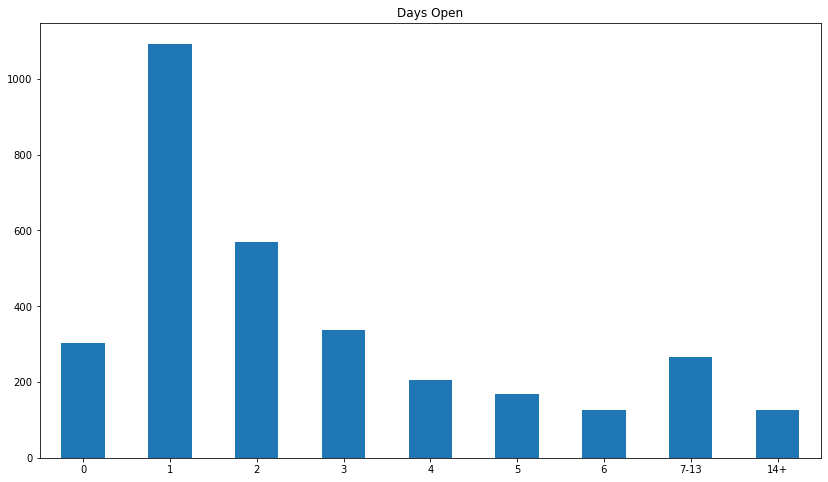

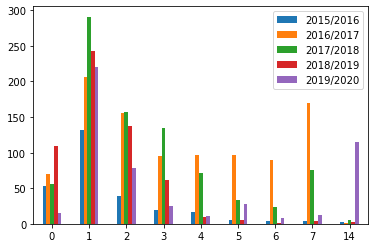

In [68]:
# Bin longer tickets'
closed.loc[closed.days_open >= 14, 'days_open'] = 14
closed.loc[closed.days_open.isin(range(7, 14)), 'days_open'] = 7

days_counts = closed['days_open'].value_counts().sort_index()

# Relabel
days_counts = days_counts.rename({14: '14+', 7: '7-13'})

# Show counts for tickets by time open overall
ax = days_counts.plot(kind='bar', rot=0,
                                    figsize=(14,8),
                       title="Days Open")
    

# Get unique seasons
values = {}
winter_buckets = closed.winter.unique()
winter_buckets.sort()
for winter in winter_buckets:
    counts = (closed[closed['winter'] == winter]['days_open'].value_counts()).sort_index()
    values[winter] = counts.values
    

df = pd.DataFrame(values, index=counts.index)
ax = df.plot.bar(rot=0)

# Also show tickets by winter
winter_counts = closed['winter'].value_counts().sort_index()
print(winter_counts)


In [89]:
def get_resolution(ticket_id, closed_time):

    for comment in comments[str(ticket_id)]:
        dt = parse(comment['created_at'])
        
        closed_time = parse(closed_time.strftime("%m/%d/%Y, %H:%M:%S"))
        # Look for comments matching ticket closed time
        # This is awkward, but Cambridge stores the time without timezone, so we need to strip that and turn it back into a datetime
        comment_time = parse(dt.strftime("%m/%d/%Y, %H:%M:%S"))

        if abs(comment_time - closed_time) <= timedelta(seconds=2):
            if 'citation was issued' in comment['comment'] \
              or 'notice was issued' in comment['comment']:
                return 'citation'
            elif 'pleased' in comment['comment'] and 'resolved' in comment['comment']:
                return 'resolved'
            elif 'new snow operation' in comment['comment'] \
              or 'suspended during this snow event' in comment['comment'] \
              or 'anticipated snowfall' in comment['comment'] \
              or 'anticipation of another snow storm' in comment['comment']:
                return 'new_snow'
            # These should probably be filtered out of the total
            elif 'we are still in an snow operation' in comment['comment'] \
              or '12 hours' in comment['comment'] \
              or 'City Ordinance' in comment['comment']:
                return 'still_snowing'
            elif 'large number of reports' in comment['comment'] and 'now in compliance' in comment['comment']:
                return 'delayed_inspection'
            elif 'we were unable to inspect this location' in comment['comment'] \
              or 'location has not been inspected' in comment['comment'] \
              or ('warm' in comment['comment'] and 'weather' in comment['comment']) \
              or ('warm' in comment['comment'] and 'temperature' in comment['comment']):
                return 'no_inspection'
            elif 'found to be in compliance' in comment['comment']:
                return 'in_compliance'
            elif 'state property' in comment['comment']:
                return 'state_property'
            elif 'duplicat' in comment['comment']:
                return 'duplicate'
            elif 'Somerville' in comment['comment']:
                return 'somerville'
            elif 'MBTA' in comment['comment']:
                return 'mbta'
            elif 'city of cambridge will' in comment['comment'].lower() \
              or 'city will' in comment['comment'].lower() \
              or 'will try and clear as soon as possible' in comment['comment'] \
              or 'city pile' in comment['comment'].lower():
                return 'city_will_address'
            else:
                #print(str(ticket_id) + "," + comment['comment'])
                return 'other'
            
    # To do: drop the ones that are closed without comment, since at the moment, it's only one
    print(str(ticket_id))
    print(closed_time)
    print(comments[str(ticket_id)])    

resolutions = defaultdict(int)
closed = closed.assign(resolution=None)
other_comments = []
for index, row in closed.iterrows():
    resolution = get_resolution(row['ticket_id'], row['ticket_closed_date_time'])
    resolutions[resolution] += 1
    closed.at[index,'resolution'] = resolution
    if resolution == 'other':
        other_comments.append(comments[str(row['ticket_id'])])

print(resolutions)
closed.head()

4235814
2018-03-14 16:09:56
[]
defaultdict(<class 'int'>, {'no_inspection': 414, 'citation': 480, 'in_compliance': 772, 'other': 182, 'resolved': 820, 'mbta': 5, 'delayed_inspection': 272, 'state_property': 48, 'new_snow': 118, 'city_will_address': 45, 'somerville': 8, 'still_snowing': 28, None: 1})


,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,winter,days_open,resolution
19,3211993,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy or Unshoveled Sidewalk,2017-02-22 14:18:28,2017-02-15 15:43:45,02/22/2017 02:18:28 PM,"27 Western Avenue Cambridge, MA",42.365244,-71.106128,"(42.3652438914, -71.1061284509)",NaN,POINT (-71.10613 42.37417),2016/2017,7,no_inspection
82,3204837,Cambridge,Icy or Unshoveled Sidewalk,closed,"Resident states lots of ""rubble"" was pushed on...",2017-02-22 14:23:01,2017-02-13 09:19:29,02/22/2017 02:23:01 PM,"Pine Street Cambridge, MA",42.365203,-71.097903,"(42.3652029, -71.0979028)",NaN,POINT (-71.09790 42.37212),2016/2017,7,no_inspection
105,2180283,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2016-01-25 13:42:50,2016-01-25 07:00:02,01/25/2016 01:42:50 PM,"278-304 Huron Ave Cambridge, MA 02138, USA",42.381380,-71.135718,"(42.3813798765, -71.1357181712)",NaN,POINT (-71.13572 42.38337),2015/2016,0,citation
106,2180717,Cambridge,Icy or Unshoveled Sidewalk,closed,Vacant house - s/w is never shoveled or sanded.,2016-01-26 12:55:54,2016-01-25 09:28:32,01/26/2016 12:55:54 PM,"16 Frances Ave Cambridge, Massachusetts",42.378364,-71.111770,"(42.3783636, -71.1117697)",NaN,POINT (-71.11177 42.35956),2015/2016,1,citation
119,2180734,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy s/w,2016-01-26 12:32:23,2016-01-25 09:30:48,01/26/2016 12:32:23 PM,"406 Broadway Cambridge, Massachusetts",42.371989,-71.108280,"(42.3719891, -71.1082801)",NaN,POINT (-71.10828 42.36988),2015/2016,1,citation


In [24]:
# Print some comments for the unassigned versions
other_resolution = closed[closed['resolution'] == 'other']
other_resolution.head()

,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,winter,days_open,resolution
130,2165690,Cambridge,Icy or Unshoveled Sidewalk,closed,This is a test,2016-01-19 12:18:47,2016-01-19 08:56:07,01/19/2016 12:18:47 PM,"147 Hampshire St Cambridge, Massachusetts",42.371354,-71.097543,"(42.3713538, -71.0975434)",NaN,POINT (-71.09754 42.36689),2015/2016,0,other
143,2167671,Cambridge,Icy or Unshoveled Sidewalk,closed,BB&N does not consistently clear this sidewalk...,2016-01-20 13:07:44,2016-01-19 19:43:28,01/20/2016 01:07:44 PM,"149-221 Fresh Pond Pkwy Cambridge, MA 02138, USA",42.382123,-71.143438,"(42.3821227455, -71.1434383231)",NaN,POINT (-71.14344 42.36455),2015/2016,1,other
358,2180407,Cambridge,Icy or Unshoveled Sidewalk,closed,Cambridge Honda does not clear access from the...,2016-01-25 14:26:34,2016-01-25 08:20:56,01/25/2016 02:26:34 PM,"263-299 Lexington Ave Cambridge, MA 02138, USA",42.383557,-71.142212,"(42.3835571637, -71.1422124668)",NaN,POINT (-71.14221 42.36252),2015/2016,0,other
497,3278966,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2017-03-20 08:57:35,2017-03-20 08:27:42,03/20/2017 08:57:35 AM,"48 Porter Street Cambridge, Massachusetts",42.373650,-71.089610,"(42.3736499, -71.0896097)",https://seeclickfix.com/files/issue_images/007...,POINT (-71.08961 42.38849),2016/2017,0,other
917,3279327,Cambridge,Icy or Unshoveled Sidewalk,closed,Still covered in snow and ice,2017-03-21 12:37:10,2017-03-20 10:25:00,03/21/2017 12:37:10 PM,"2-20 Reardon St Cambridge, MA 02139, USA",42.356485,-71.103860,"(42.356484868, -71.103859843)",NaN,POINT (-71.10386 42.37288),2016/2017,1,other


In [25]:
# To do: filter on role: "Verified Official"

In [26]:
# What sorts of resolution types do we see by days it takes to close a ticket?
zero_days = closed[closed['days_open'] == 0]
zero_days.head()

,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,winter,days_open,resolution
105,2180283,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2016-01-25 13:42:50,2016-01-25 07:00:02,01/25/2016 01:42:50 PM,"278-304 Huron Ave Cambridge, MA 02138, USA",42.381380,-71.135718,"(42.3813798765, -71.1357181712)",NaN,POINT (-71.13572 42.38337),2015/2016,0,citation
130,2165690,Cambridge,Icy or Unshoveled Sidewalk,closed,This is a test,2016-01-19 12:18:47,2016-01-19 08:56:07,01/19/2016 12:18:47 PM,"147 Hampshire St Cambridge, Massachusetts",42.371354,-71.097543,"(42.3713538, -71.0975434)",NaN,POINT (-71.09754 42.36689),2015/2016,0,other
152,2168113,Cambridge,Icy or Unshoveled Sidewalk,closed,Nobody shoveled. Sidewalk is hazardous.,2016-01-20 10:48:58,2016-01-19 23:22:30,01/20/2016 10:48:58 AM,"35 Madison Ave Cambridge, Massachusetts",42.399371,-71.135953,"(42.3993707396, -71.1359529197)",NaN,POINT (-71.13595 42.37415),2015/2016,0,None
153,2168120,Cambridge,Icy or Unshoveled Sidewalk,closed,Sidewalk is covered in snow and ice. Hazardous...,2016-01-20 10:42:24,2016-01-19 23:30:44,01/20/2016 10:42:24 AM,"29 Magoun Street Cambridge, Massachusetts",42.399709,-71.135395,"(42.3997091522, -71.1353946462)",NaN,POINT (-71.13539 42.38977),2015/2016,0,citation
218,2172118,Cambridge,Icy or Unshoveled Sidewalk,closed,Sidewalk is very icy,2016-01-21 13:41:11,2016-01-21 09:22:52,01/21/2016 01:41:11 PM,"Windsor And Mass. Av. Cambridge, Massachusetts",42.361485,-71.096952,"(42.3614846248, -71.0969515619)",NaN,POINT (-71.09695 42.37252),2015/2016,0,in_compliance


In [27]:
p = figure(x_range=(-7919969.67, -7911590.87), y_range=(5221575.24, 5214113.74), x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
show(p)

#coords = [[-9759284.802320646, -9759781.18], [5139718.458609748, 5162158.11]]    
#p.line(x=coords[0], y=coords[1])